# TimeEval parameter optimization result analysis (Part 5)

In [1]:
# imports
import json
import warnings
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt

from pathlib import Path
from timeeval import Datasets

## Configuration

Define data and results folder:

In [3]:
# constants and configuration
data_path = Path("/home/projects/akita/data") / "test-cases"
result_root_path = Path("/home/projects/akita/results")
experiment_result_folder = "2021-10-12_optim-part5"

# build paths
result_paths = [d for d in result_root_path.iterdir() if d.is_dir()]
print("Available result directories:")
display(result_paths)

result_path = result_root_path / experiment_result_folder
print("\nSelecting:")
print(f"Data path: {data_path.resolve()}")
print(f"Result path: {result_path.resolve()}")

Available result directories:


[PosixPath('/home/projects/akita/results/2021-10-11_optim-part4'),
 PosixPath('/home/projects/akita/results/2021-09-27_shared-optim'),
 PosixPath('/home/projects/akita/results/2021-10-06_optim-part1'),
 PosixPath('/home/projects/akita/results/2021-09-27_default-params-1&2&3&4-merged'),
 PosixPath('/home/projects/akita/results/.ipynb_checkpoints'),
 PosixPath('/home/projects/akita/results/2021-10-08_optim-part3'),
 PosixPath('/home/projects/akita/results/2021-10-07_optim-part2'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part5'),
 PosixPath('/home/projects/akita/results/2021-10-12_optim-part6')]


Selecting:
Data path: /home/projects/akita/data/test-cases
Result path: /home/projects/akita/results/2021-10-12_optim-part5


Load results and dataset metadata:

In [4]:
# load results
print(f"Reading results from {result_path.resolve()}")
df = pd.read_csv(result_path / "results.csv")

# add dataset_name column
df["dataset_name"] = df["dataset"].str.split(".").str[0]

# load dataset metadata
dmgr = Datasets(data_path)

Reading results from /home/projects/akita/results/2021-10-12_optim-part5


Extract target optimized parameter names that were iterated in this run (per algorithm):

In [6]:
algo_param_mapping = {}
algorithms = df["algorithm"].unique()
param_ignore_list = ["max_anomaly_window_size", "anomaly_window_size", "neighbourhood_size", "window_size", "n_init_train", "embed_dim_range", "query_window_size"]

for algo in algorithms:
    param_sets = df.loc[df["algorithm"] == algo, "hyper_params"].unique()
    param_sets = [json.loads(ps) for ps in param_sets]
    param_names = np.unique([name for ps in param_sets for name in ps if name not in param_ignore_list])
    search_space = set()
    for param_name in param_names:
        values = []
        for ps in param_sets:
            try:
                values.append(ps[param_name])
            except:
                pass
        values = np.unique(values)
        if values.shape[0] > 1:
            search_space.add(param_name)
    algo_param_mapping[algo] = list(search_space)

for algo in algo_param_mapping:
    print(algo, algo_param_mapping[algo])

Series2Graph ['rate']
Spectral Residual (SR) []
Subsequence IF ['bootstrap']
Subsequence LOF []
TARZAN ['alphabet_size']


Extract optimized parameters and their values (columns: optim_param_name and optim_param_value) for each experiment:

In [7]:
def extract_hyper_params(algo):
    param_names = algo_param_mapping[algo]
    def extract(value):
        params = json.loads(value)
        result = None
        for name in param_names:
            try:
                value = params[name]
                if isinstance(value, list):
                    value = repr(value)
                result = pd.Series([name, value], index=["optim_param_name", "optim_param_value"])
                break
            except KeyError:
                pass
        if result is None:
            return pd.Series([np.nan, np.nan], index=["optim_param_name", "optim_param_value"])
        return result
    return extract

df[["optim_param_name", "optim_param_value"]] = ""
for algo in algo_param_mapping:
    df_algo = df.loc[df["algorithm"] == algo]
    df.loc[df_algo.index, ["optim_param_name", "optim_param_value"]] = df_algo["hyper_params"].apply(extract_hyper_params(algo))

Extract window size parameters (dependent params) and convert them into multiples of the dataset period size:

In [8]:
dependent_param_names = ["neighbourhood_size", "window_size"]

def extract_window_param(value, param_name=""):
    params = json.loads(value)
    try:
        return params[param_name]
    except KeyError:
        return 0

for param_name in dependent_param_names:
    s_windows = df["hyper_params"].apply(extract_window_param, param_name=param_name)
    df2 = df[s_windows > 0][["dataset"]].copy()
    df2[param_name] = s_windows[df2.index]
    df2["period_size"] = df2["dataset"].apply(lambda d: dmgr.get(("GutenTAG", d)).period_size)
    df2["optim_param_name"] = param_name
    df2["optim_param_value"] = df2[param_name] / df2["period_size"]
    df2["optim_param_value"] = (df2["optim_param_value"]
                                .fillna(df2[param_name])
                                .round(1)
                                .replace(50., 0.5)
                                .replace(100, 1.0)
                                .replace(150, 1.5)
                                .replace(200, 2.0))
    df.loc[df2.index, ["optim_param_name", "optim_param_value"]] = df2[["optim_param_name", "optim_param_value"]]

Define utility functions

In [9]:
def load_scores_df(algorithm_name, dataset_id, optim_params, repetition=1):
    params_id = df.loc[(df["algorithm"] == algorithm_name) & (df["collection"] == dataset_id[0]) & (df["dataset"] == dataset_id[1]) & (df["optim_param_name"] == optim_params[0]) & (df["optim_param_value"] == optim_params[1]), "hyper_params_id"].item()
    path = (
        result_path /
        algorithm_name /
        params_id /
        dataset_id[0] /
        dataset_id[1] /
        str(repetition) /
        "anomaly_scores.ts"
    )
    return pd.read_csv(path, header=None)

Define plotting functions:

In [10]:
default_use_plotly = True
try:
    import plotly.offline
except ImportError:
    default_use_plotly = False

def plot_scores(algorithm_name, dataset_name, use_plotly: bool = default_use_plotly, **kwargs):
    if isinstance(algorithm_name, tuple):
        algorithms = [algorithm_name]
    elif not isinstance(algorithm_name, list):
        raise ValueError("Please supply a tuple (algorithm_name, optim_param_name, optim_param_value) or a list thereof as first argument!")
    else:
        algorithms = algorithm_name
    # construct dataset ID
    dataset_id = ("GutenTAG", f"{dataset_name}.unsupervised")

    # load dataset details
    df_dataset = dmgr.get_dataset_df(dataset_id)

    # check if dataset is multivariate
    dataset_dim = df.loc[df["dataset_name"] == dataset_name, "dataset_input_dimensionality"].unique().item()
    dataset_dim = dataset_dim.lower()
    
    auroc = {}
    df_scores = pd.DataFrame(index=df_dataset.index)
    skip_algos = []
    algos = []
    for algo, optim_param_name, optim_param_value in algorithms:
        optim_params = f"{optim_param_name}={optim_param_value}"
        algos.append((algo, optim_params))
        # get algorithm metric results
        try:
            auroc[(algo, optim_params)] = df.loc[
                (df["algorithm"] == algo) & (df["dataset_name"] == dataset_name) & (df["optim_param_name"] == optim_param_name) & (df["optim_param_value"] == optim_param_value),
                "ROC_AUC"
            ].item()
        except ValueError:
            warnings.warn(f"No ROC_AUC score found! Probably {algo} with params {optim_params} was not executed on {dataset_name}.")
            auroc[(algo, optim_params)] = -1
            skip_algos.append((algo, optim_params))
            continue

        # load scores
        training_type = df.loc[df["algorithm"] == algo, "algo_training_type"].values[0].lower().replace("_", "-")
        try:
            df_scores[(algo, optim_params)] = load_scores_df(algo, ("GutenTAG", f"{dataset_name}.{training_type}"), (optim_param_name, optim_param_value)).iloc[:, 0]
        except (ValueError, FileNotFoundError):
            warnings.warn(f"No anomaly scores found! Probably {algo} was not executed on {dataset_name} with params {optim_params}.")
            df_scores[(algo, optim_params)] = np.nan
            skip_algos.append((algo, optim_params))
    algorithms = [a for a in algos if a not in skip_algos]

    if use_plotly:
        return plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)
    else:
        return plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs)

def plot_scores_plotly(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import plotly.offline as py
    import plotly.graph_objects as go
    import plotly.figure_factory as ff
    import plotly.express as px
    from plotly.subplots import make_subplots

    # Create plot
    fig = make_subplots(2, 1)
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, i], name=f"channel-{i}"), 1, 1)
    else:
        fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset.iloc[:, 1], name="timeseries"), 1, 1)
    fig.add_trace(go.Scatter(x=df_dataset.index, y=df_dataset["is_anomaly"], name="label"), 2, 1)
    
    for item in algorithms:
        algo, optim_params = item
        fig.add_trace(go.Scatter(x=df_scores.index, y=df_scores[item], name=f"{algo}={auroc[item]:.4f} ({optim_params})"), 2, 1)
    fig.update_xaxes(matches="x")
    fig.update_layout(
        title=f"Results of {','.join(np.unique([a for a, _ in algorithms]))} on {dataset_name}",
        height=400
    )
    return py.iplot(fig)

def plot_scores_plt(algorithms, auroc, df_scores, df_dataset, dataset_dim, dataset_name, **kwargs):
    import matplotlib.pyplot as plt

    # Create plot
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
    if dataset_dim == "multivariate":
        for i in range(1, df_dataset.shape[1]-1):
            axs[0].plot(df_dataset.index, df_dataset.iloc[:, i], label=f"channel-{i}")
    else:
        axs[0].plot(df_dataset.index, df_dataset.iloc[:, 1], label=f"timeseries")
    axs[1].plot(df_dataset.index, df_dataset["is_anomaly"], label="label")
    
    for item in algorithms:
        algo, optim_params = item
        axs[1].plot(df_scores.index, df_scores[item], label=f"{algo}={auroc[item]:.4f} ({optim_params})")
    axs[0].legend()
    axs[1].legend()
    fig.suptitle(f"Results of {','.join(np.unique([a for a, _ in algorithms]))} on {dataset_name}")
    fig.tight_layout()
    return fig

## Parameter assessment

In [11]:
sort_by = ("ROC_AUC", "mean")
metric_agg_type = ["min", "mean", "median"]
time_agg_type = "mean"
aggs = {
    "PR_AUC": metric_agg_type,
    "ROC_AUC": metric_agg_type,
    "train_main_time": time_agg_type,
    "execute_main_time": time_agg_type,
    "repetition": "count"
}

df_tmp = df.reset_index()
df_tmp = df_tmp.groupby(by=["algorithm", "optim_param_name", "optim_param_value"]).agg(aggs)
df_tmp = df_tmp.reset_index()
df_tmp = df_tmp.sort_values(by=["algorithm", "optim_param_name", sort_by], ascending=False)
df_tmp = df_tmp.set_index(["algorithm", "optim_param_name", "optim_param_value"])

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df_tmp)

PR_AUC            \
                                                                min      mean   
algorithm              optim_param_name optim_param_value                       
TARZAN                 alphabet_size    4                  0.000500  0.145229   
                                        3                  0.000501  0.099021   
                                        5                  0.000500  0.071180   
                                        6                  0.000500  0.046914   
Subsequence LOF        window_size      1.0                0.002063  0.663537   
                                        1.5                0.000679  0.661492   
                                        2.0                0.000242  0.643869   
                                        0.5                0.002841  0.647351   
Subsequence IF         window_size      1.5                0.000059  0.311451   
                                        1.0                0.000056  0.337544   
                                        2.0                0.000057  0.331300   
                                        0.5                0.000060  0.271920   
                       bootstrap        1.0                0.000057  0.365066   
                                        False              0.000056  0.369956   
Spectral Residual (SR) window_size      2.0                0.000050  0.122641   
                                        1.5                0.000050  0.115922   
                                        0.5                0.000050  0.112711   
                                        1.0                0.000050  0.112866   
Series2Graph           window_size      1.0                0.000063  0.380729   
                                        0.5                0.000052  0.384767   
                                        2.0                0.000058  0.371451   
                                        1.5                0.000054  0.363603   
                       rate             30.0               0.000083  0.433465   
                                        100.0              0.000106  0.441145   
                                        50.0               0.000088  0.423850   

                                                                      ROC_AUC  \
                                                             median       min   
algorithm              optim_param_name optim_param_value                       
TARZAN                 alphabet_size    4                  0.052556  0.000571   
                                        3                  0.023213  0.001026   
                                        5                  0.011948  0.000400   
                                        6                  0.010142  0.000430   
Subsequence LOF        window_size      1.0                0.769821  0.341819   
                                        1.5                0.779934  0.112112   
                                        2.0                0.717432  0.086879   
                                        0.5                0.801604  0.270448   
Subsequence IF         window_size      1.5                0.118341  0.000032   
                                        1.0                0.153736  0.000022   
                                        2.0                0.126975  0.000028   
                                        0.5                0.104251  0.006099   
                       bootstrap        1.0                0.165821  0.000028   
                                        False              0.160814  0.000021   
Spectral Residual (SR) window_size      2.0                0.047574  0.002450   
                                        1.5                0.044188  0.003300   
                                        0.5                0.049911  0.009951   
                                        1.0                0.055248  0.004950   
Series2Graph           window_size      1.0                0.175612  0.090255   
          

#### Selected parameters

- TARZAN: `alphabet_size=4` (**overall bad performance** (below 0.5 AUROC!?) and **sensitive** to parameter choice)
- Subsequence LOF: `window_size="1.0 * dataset period size"` (seems to be very robust)
- Subsequence IF: `window_size="1.0 * dataset period size",bootstrap=True` (seems to be very robust; bootstrap doesn't change much)
- Spectral Residual (SR): `window_size="2.0 * dataset period size"`
- Series2Graph: `window_size="1.0 * dataset period size",rate=100` (seems to be very robust, but direct hit of window_size gives a boost)

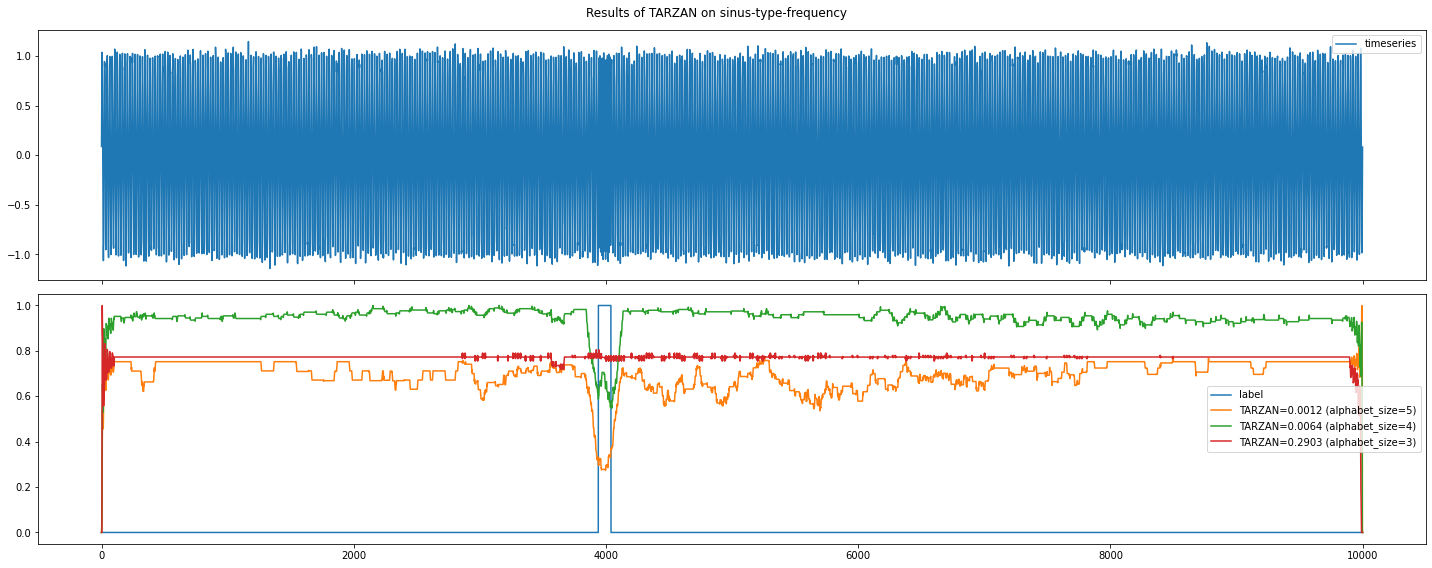

In [23]:
plot_scores([
    ("TARZAN", "alphabet_size", 5),
    ("TARZAN", "alphabet_size", 4),
    ("TARZAN", "alphabet_size", 3)
], "sinus-type-frequency", use_plotly=False)
plt.show()

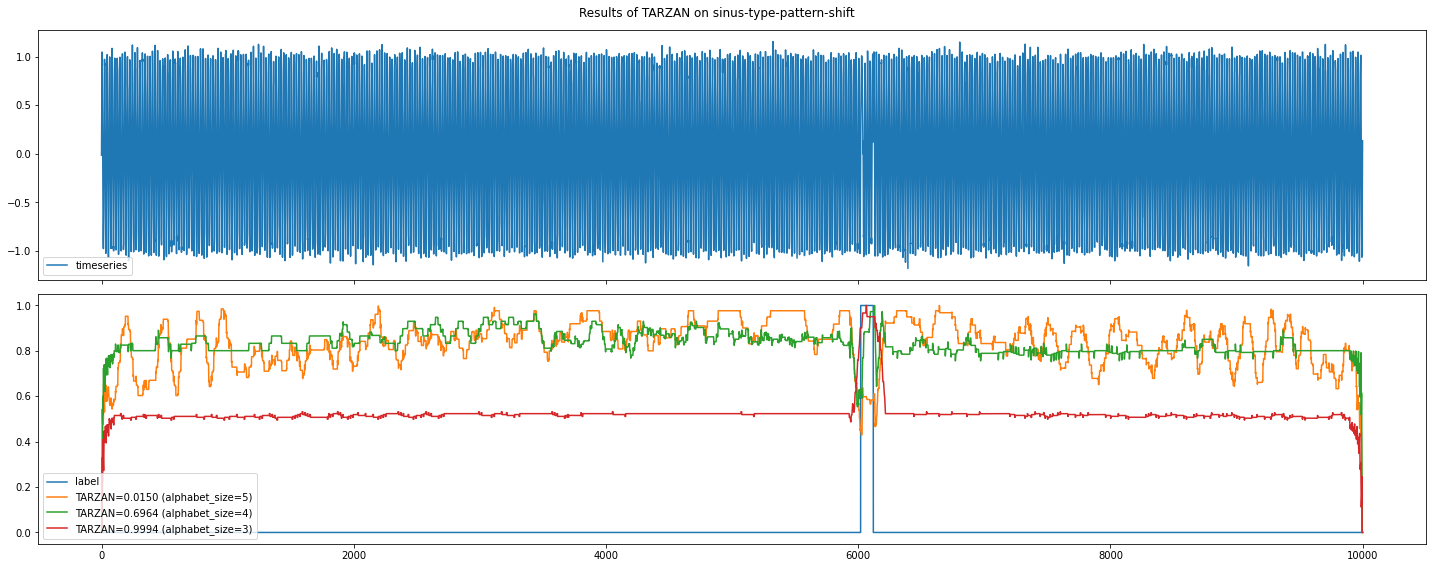

In [27]:
plot_scores([
    ("TARZAN", "alphabet_size", 5),
    ("TARZAN", "alphabet_size", 4),
    ("TARZAN", "alphabet_size", 3)
], "sinus-type-pattern-shift", use_plotly=False)
plt.show()